In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from keras.applications import DenseNet169, DenseNet201,MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D, Dropout

from sklearn import preprocessing, metrics
from keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
import xgboost as xgb

In [7]:
def visualize_confusion_matrix(matrix, model_name):
    emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Purples', xticklabels=emotion_classes, yticklabels=emotion_classes)
    plt.xlabel('Predicted labels', fontsize=12, fontweight='bold')
    plt.ylabel('True labels', fontsize=12, fontweight='bold')
    plt.title(f'{model_name} Confusion Matrix', fontsize=16, fontweight='bold')
    plt.show()

In [8]:
def visualize_emotion_prediction_stats(matrix, model_name):
    emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    emotion_counts = []
    correct_predictions = np.diag(matrix)

    for i in range(len(emotion_classes)):
        emotion_counts.append(np.sum(matrix[i, :]))

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(emotion_classes))
    opacity = 0.8

    rects1 = plt.bar(index, emotion_counts, bar_width, alpha=opacity, color='#a6a6f1', label='Total')
    rects2 = plt.bar(index + bar_width, correct_predictions, bar_width, alpha=opacity, color='#a6f1cc', label='Correct')

    plt.xlabel('Emotions', fontsize=12, fontweight='bold')
    plt.ylabel('Counts', fontsize=12, fontweight='bold')
    plt.title(f'Emotion Counts and Correct Predictions ({model_name})', fontsize=16, fontweight='bold')
    plt.xticks(index + bar_width / 2, emotion_classes)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def overview_dataset_statistics(matrix, model_name):
    visualize_confusion_matrix(matrix, model_name)
    visualize_emotion_prediction_stats(matrix, model_name)

In [10]:
IMG_SIZE=112

In [14]:
train_images = []
train_labels = []
for directory_path in glob.glob("/kaggle/input/fer2013/train/*"):
    label = os.path.basename(directory_path)
    print("Completed", label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

train_labels = np.array(train_labels)

test_images = []
test_labels = []
for directory_path in glob.glob("/kaggle/input/fer2013/test/*"):
    label = os.path.basename(directory_path)
    print("Completed", label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)

test_labels = np.array(test_labels)

x_train = np.array(train_images, dtype=np.float32) / 255.0
x_test = np.array(test_images, dtype=np.float32) / 255.0

Completed surprise
Completed fear
Completed angry
Completed neutral
Completed sad
Completed disgust
Completed happy
Completed surprise
Completed fear
Completed angry
Completed neutral
Completed sad
Completed disgust
Completed happy


In [15]:
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)
test_labels_encoded = le.transform(test_labels)
y_train = to_categorical(train_labels_encoded)
y_test = to_categorical(test_labels_encoded)

In [16]:
train_data_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)
train_data_generator.fit(x_train)

In [17]:
def extract_features(model, data):
    features = model.predict(data)
    return features.reshape(features.shape[0], -1)

In [18]:
def train_and_evaluate_classifier(classifier, train_features, test_features, train_labels, test_labels, label_encoder):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features)
    predictions = label_encoder.inverse_transform(predictions)
    accuracy = accuracy_score(test_labels, predictions)
    report = classification_report(test_labels, predictions)
    matrix = confusion_matrix(test_labels, predictions)
    return accuracy, report, matrix

In [19]:
def train_and_evaluate_model(base_model):
    predictions = base_model.predict(x_test)
    predictions = np.argmax(predictions, axis=1)
    test_labels = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(test_labels, predictions)
    report = classification_report(test_labels, predictions)
    matrix = confusion_matrix(test_labels, predictions)
    
    return accuracy, report, matrix

In [20]:
def build_cnn_model(base_model):
    x = Flatten()(base_model.output)    
    x = Dense(256, activation='relu')(x)
    predictions = Dense(7, activation='softmax')(x)
    
    cnn_model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn_model

# *Traditional Machine Learning Classification*

In [21]:
rf_classifier = RandomForestClassifier(n_estimators=300, min_samples_leaf=1, min_samples_split=2, max_depth=30, random_state=42)

In [22]:
xgb_classifier=xgb.XGBClassifier()

In [23]:
knn_classifier = KNeighborsClassifier(n_neighbors=1)

----


# **1.VGG16**

In [20]:
vgg16_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in vgg16_model.layers:
    layer.trainable = False

vgg16_train_features = extract_features(vgg16_model, x_train)
vgg16_test_features = extract_features(vgg16_model, x_test)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
 10/898 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step

I0000 00:00:1717511523.875106     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step


* **RANDOM FOREST CLASSIFICATION**

In [14]:
rf_acc, rf_report, rf_matrix = train_and_evaluate_classifier(rf_classifier, vgg16_train_features, vgg16_test_features, train_labels_encoded, test_labels, le)
print("Random Forest done")

Random Forest done


In [18]:
print("VGG16 + Random Forest Accuracy: {:.2f}%".format(rf_acc * 100) )
print("VGG16 + Random Forest Classification Report:\n", rf_report)

VGG16 + Random Forest Accuracy: 51.14%
VGG16 + Random Forest Classification Report:
               precision    recall  f1-score   support

       angry       0.62      0.23      0.34       958
     disgust       1.00      0.36      0.53       111
        fear       0.67      0.32      0.43      1024
       happy       0.47      0.83      0.60      1774
     neutral       0.46      0.41      0.43      1233
         sad       0.42      0.41      0.41      1247
    surprise       0.74      0.69      0.72       831

    accuracy                           0.51      7178
   macro avg       0.62      0.47      0.50      7178
weighted avg       0.55      0.51      0.49      7178



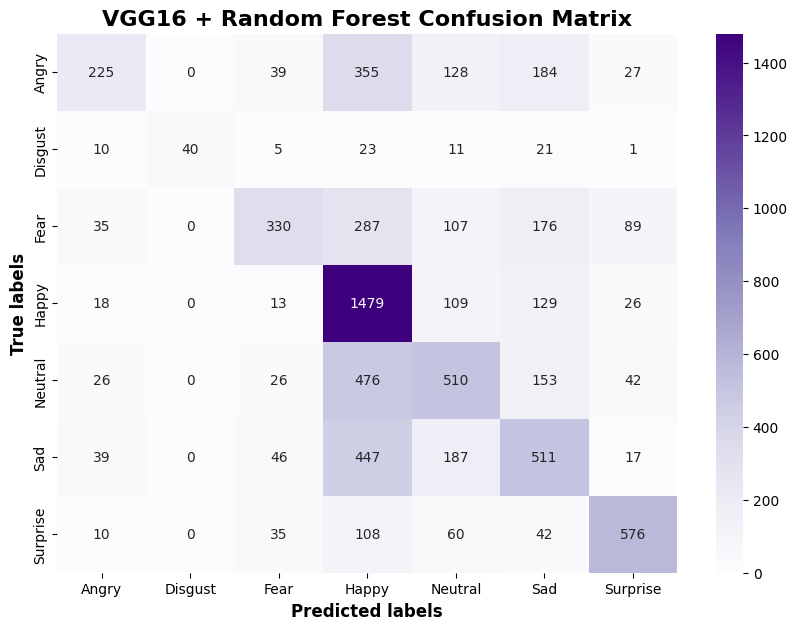

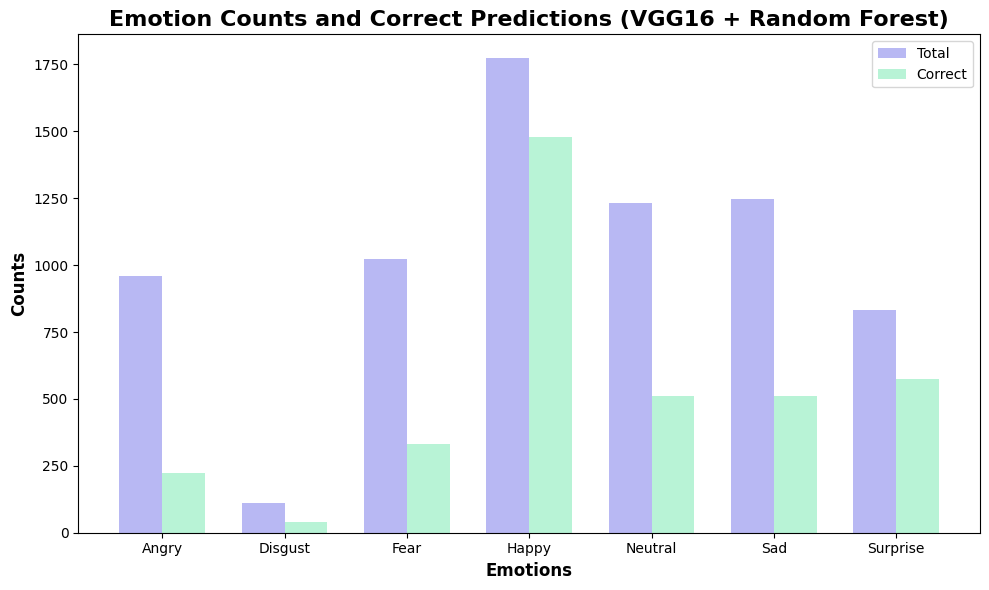

In [19]:
overview_dataset_statistics(rf_matrix, "VGG16 + Random Forest")

* **XGBOOST CLASSIFICATION**

In [22]:
xgb_acc, xgb_report, xgb_matrix = train_and_evaluate_classifier(xgb_classifier, vgg16_train_features, vgg16_test_features, train_labels_encoded, test_labels, le)
print("XGBoost done")

XGB Forest done


In [23]:
print("VGG16 + XGBoost Accuracy: {:.2f}%".format(xgb_acc * 100) )
print("VGG16 + XGBoost Classification Report:\n", xgb_report)

VGG16 + XGBoost Accuracy: 54.49%
VGG16 + XGBoost Classification Report:
               precision    recall  f1-score   support

       angry       0.47      0.37      0.41       958
     disgust       0.96      0.41      0.57       111
        fear       0.49      0.38      0.43      1024
       happy       0.62      0.78      0.69      1774
     neutral       0.46      0.52      0.49      1233
         sad       0.44      0.43      0.44      1247
    surprise       0.75      0.68      0.71       831

    accuracy                           0.54      7178
   macro avg       0.60      0.51      0.53      7178
weighted avg       0.54      0.54      0.54      7178



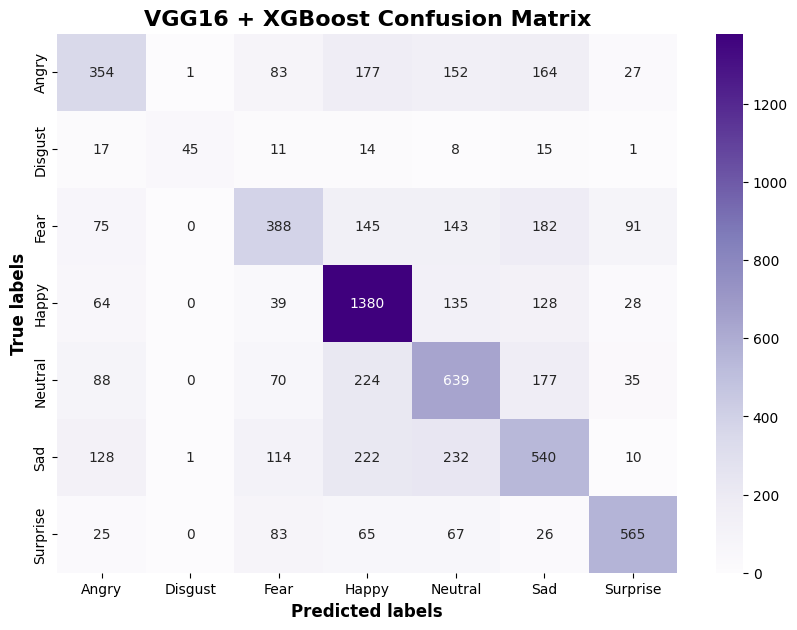

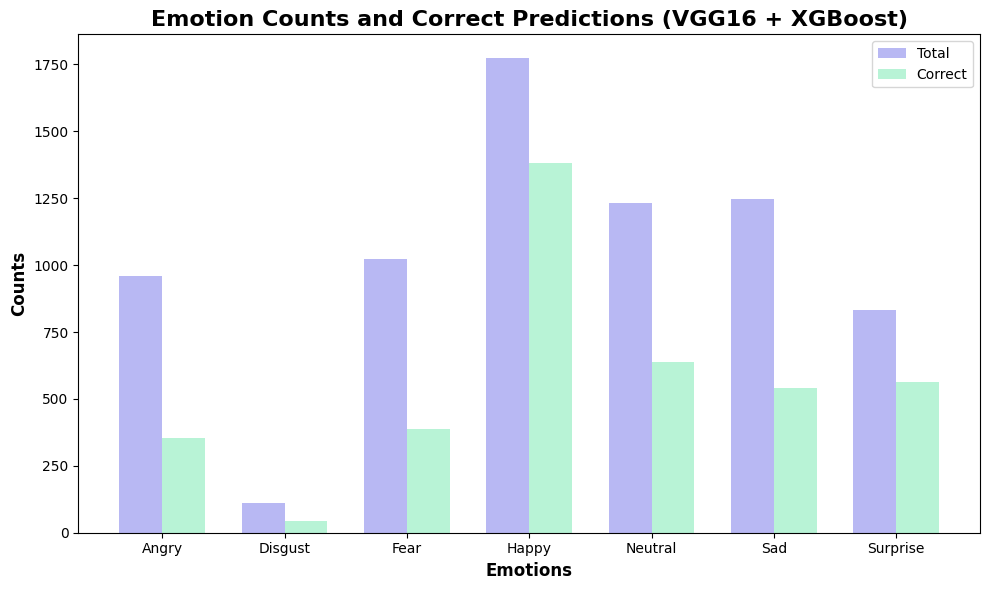

In [24]:
overview_dataset_statistics(xgb_matrix, "VGG16 + XGBoost")

* **KNN CLASSIFICATION**

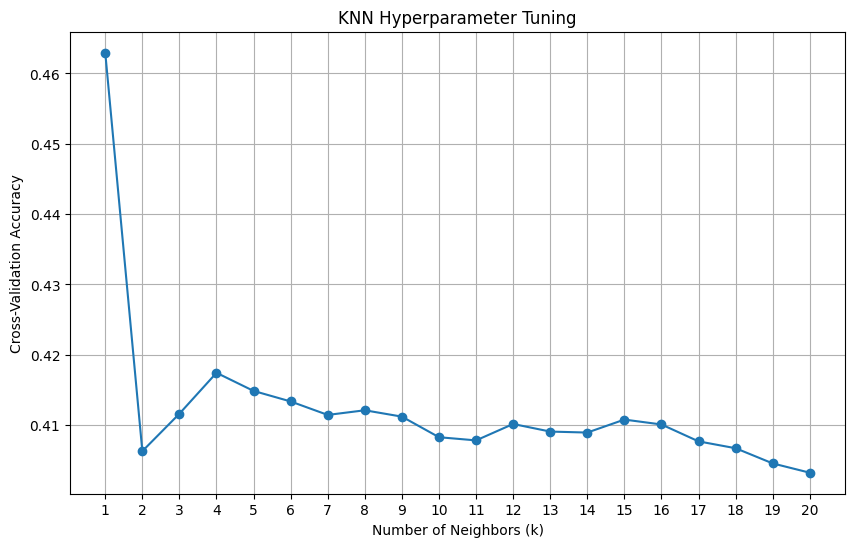

The best number of neighbors is 1 with accuracy 0.4629551647510792
KNN Classifier done
KNN Accuracy: 0.4909445528002229
KNN Classification Report:
               precision    recall  f1-score   support

       angry       0.44      0.42      0.43       958
     disgust       0.40      0.65      0.49       111
        fear       0.48      0.46      0.47      1024
       happy       0.53      0.56      0.54      1774
     neutral       0.41      0.44      0.42      1233
         sad       0.42      0.39      0.40      1247
    surprise       0.75      0.68      0.71       831

    accuracy                           0.49      7178
   macro avg       0.49      0.51      0.50      7178
weighted avg       0.49      0.49      0.49      7178



In [27]:
k_values = range(1, 21)
k_scores = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, vgg16_train_features, train_labels_encoded, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, marker='o')
plt.title('KNN Hyperparameter Tuning')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(k_scores)]
print(f"The best number of neighbors is {best_k} with accuracy {max(k_scores)}")

knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_acc, knn_report, knn_matrix = train_and_evaluate_classifier(knn_classifier, vgg16_train_features, vgg16_test_features, train_labels_encoded, test_labels, le)
print("KNN Classifier done")

print("KNN Accuracy:", knn_acc)
print("KNN Classification Report:\n", knn_report)

In [21]:
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_acc, knn_report, knn_matrix = train_and_evaluate_classifier(knn_classifier, vgg16_train_features, vgg16_test_features, train_labels_encoded, test_labels, le)
print("KNN Classifier done")

KNN Classifier done


In [22]:
print("VGG16 + KNN Accuracy: {:.2f}%".format(knn_acc * 100) )
print("VGG16 + KNN Classification Report:\n", knn_report)

VGG16 + KNN Accuracy: 49.09%
VGG16 + KNN Classification Report:
               precision    recall  f1-score   support

       angry       0.44      0.42      0.43       958
     disgust       0.40      0.65      0.49       111
        fear       0.48      0.46      0.47      1024
       happy       0.53      0.56      0.54      1774
     neutral       0.41      0.44      0.42      1233
         sad       0.42      0.39      0.40      1247
    surprise       0.75      0.68      0.71       831

    accuracy                           0.49      7178
   macro avg       0.49      0.51      0.50      7178
weighted avg       0.49      0.49      0.49      7178



trb rulat cu scris knn****

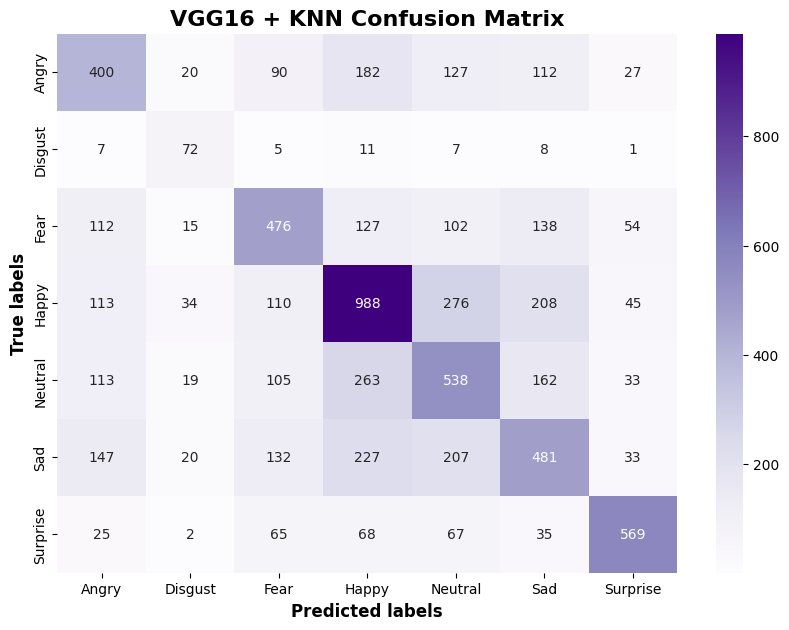

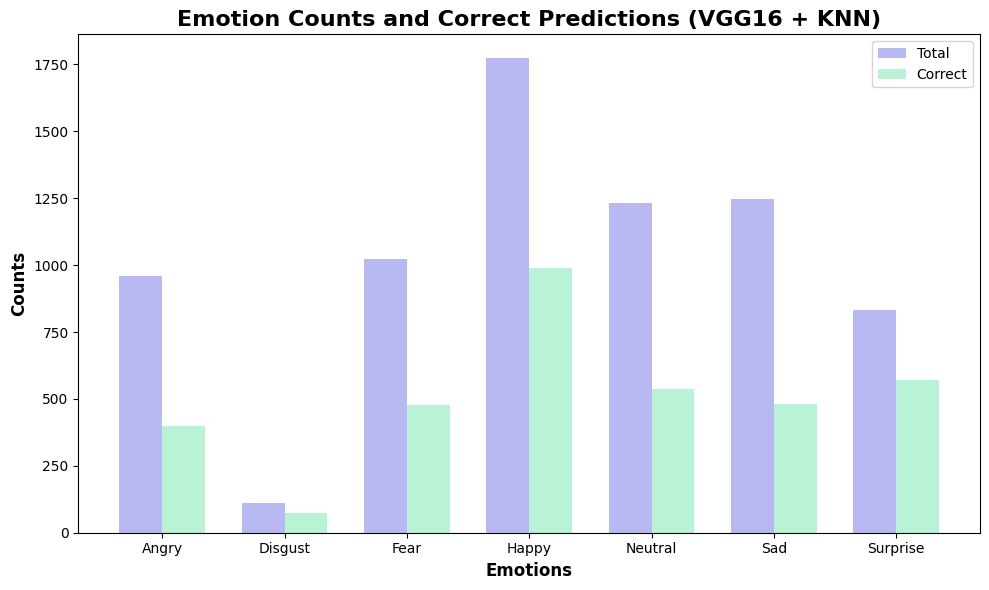

In [23]:
overview_dataset_statistics(knn_matrix, "VGG16 + KNN")

# *Deep Learning Classification*


* **NEURAL NETWORK CLASSIFICATION**

In [32]:
vgg16_cnn_model=build_cnn_model(vgg16_model)

In [34]:
vgg16_cnn_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4012 - loss: 1.5666

W0000 00:00:1717438152.987865     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.4012 - loss: 1.5670 - val_accuracy: 0.4043 - val_loss: 1.6166
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.4664 - loss: 1.5038 - val_accuracy: 0.3849 - val_loss: 1.9940
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.4726 - loss: 1.8540 - val_accuracy: 0.4055 - val_loss: 3.2198
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.4447 - loss: 4.2747 - val_accuracy: 0.2678 - val_loss: 4.4796
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.4294 - loss: 5.0651 - val_accuracy: 0.2062 - val_loss: 5.5215
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.3919 - loss: 9.8797 - val_accuracy: 0.3901 - val_loss: 4.7986
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.4540 - loss: 6.5937 - val_accuracy: 0.1861 - val_loss: 6.1688
Epoch 8/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.4010 - loss: 8.4238 - val_accurac

In [ ]:
def train_and_evaluate_classifier(classifier, train_features, test_features, train_labels, test_labels, label_encoder):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features)
    predictions = label_encoder.inverse_transform(predictions)
    accuracy = accuracy_score(test_labels, predictions)
    report = classification_report(test_labels, predictions)
    matrix = confusion_matrix(test_labels, predictions)
    return accuracy, report, matrix

In [44]:
predictions = vgg16_cnn_model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(y_test, axis=1)
cnn_acc = accuracy_score(test_labels, predictions)
cnn_report = classification_report(test_labels, predictions)
cnn_matrix = confusion_matrix(test_labels, predictions)


225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print("VGG16 + DeepLearning Accuracy: {:.2f}%".format(cnn_acc * 100) )
print("VGG16 + DeepLearning Classification Report:\n", cnn_report)

VGG16 + DeepLearning Accuracy: 22.23%
VGG16 + DeepLearning Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.18      0.59      0.27      1024
           3       0.00      0.00      0.00      1774
           4       0.27      0.57      0.37      1233
           5       0.24      0.22      0.23      1247
           6       0.82      0.01      0.02       831

    accuracy                           0.22      7178
   macro avg       0.36      0.20      0.13      7178
weighted avg       0.34      0.22      0.14      7178



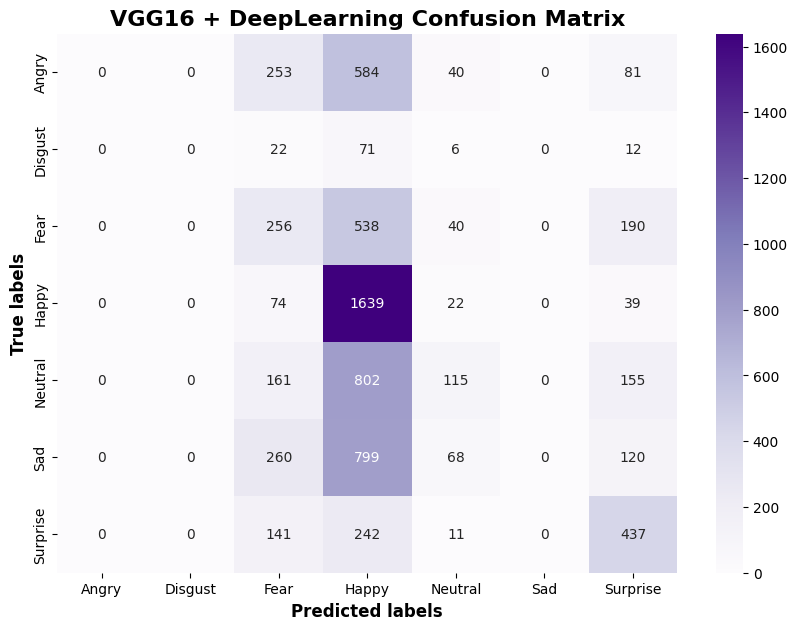

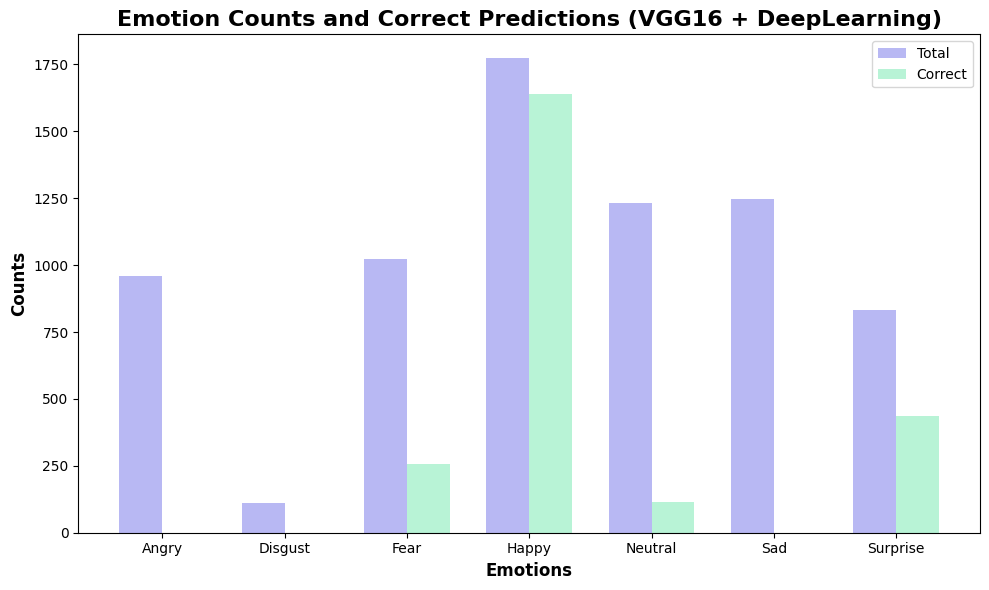

In [45]:
overview_dataset_statistics(cnn_matrix, "VGG16 + DeepLearning")

# **2. Densenet169**

In [24]:
densenet169_model = DenseNet169(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in densenet169_model.layers:
    layer.trainable = False

densenet169_train_features = extract_features(densenet169_model, x_train)
densenet169_test_features = extract_features(densenet169_model, x_test)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
898/898 ━━━━━━━━━━━━━━━━━━━━ 64s 45ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step


* **RANDOM FOREST CLASSIFICATION**

In [20]:
rf_acc, rf_report, rf_matrix = train_and_evaluate_classifier(rf_classifier, densenet169_train_features, densenet169_test_features, train_labels_encoded, test_labels, le)
print("Random Forest done")

Random Forest done


In [22]:
print("Densenet169 + Random Forest Accuracy: {:.2f}%".format(rf_acc * 100))
print("Densenet169 + Random Forest Classification Report:\n", rf_report)

Densenet169 + Random Forest Accuracy: 53.62%
Densenet169 + Random Forest Classification Report:
               precision    recall  f1-score   support

       angry       0.52      0.30      0.38       958
     disgust       1.00      0.30      0.46       111
        fear       0.55      0.29      0.38      1024
       happy       0.56      0.83      0.67      1774
     neutral       0.49      0.51      0.50      1233
         sad       0.42      0.47      0.44      1247
    surprise       0.74      0.68      0.71       831

    accuracy                           0.54      7178
   macro avg       0.61      0.48      0.50      7178
weighted avg       0.54      0.54      0.52      7178



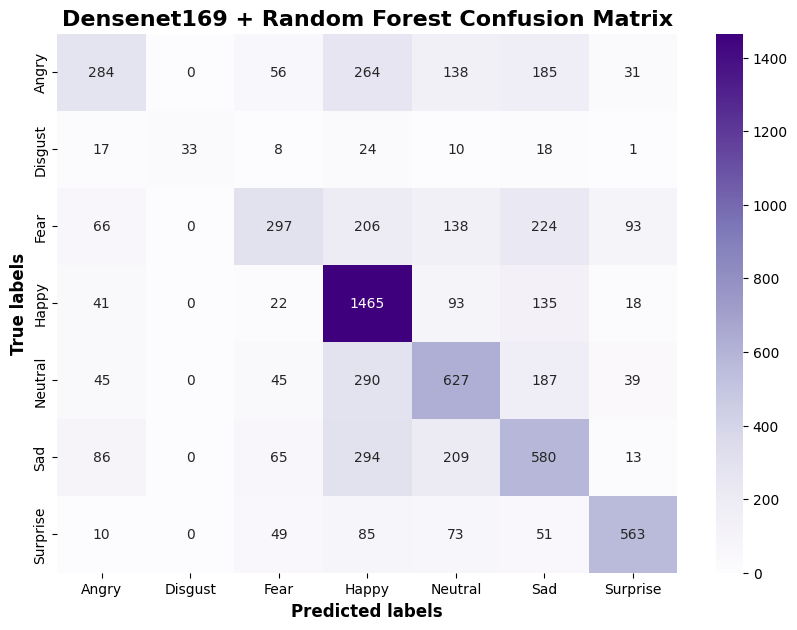

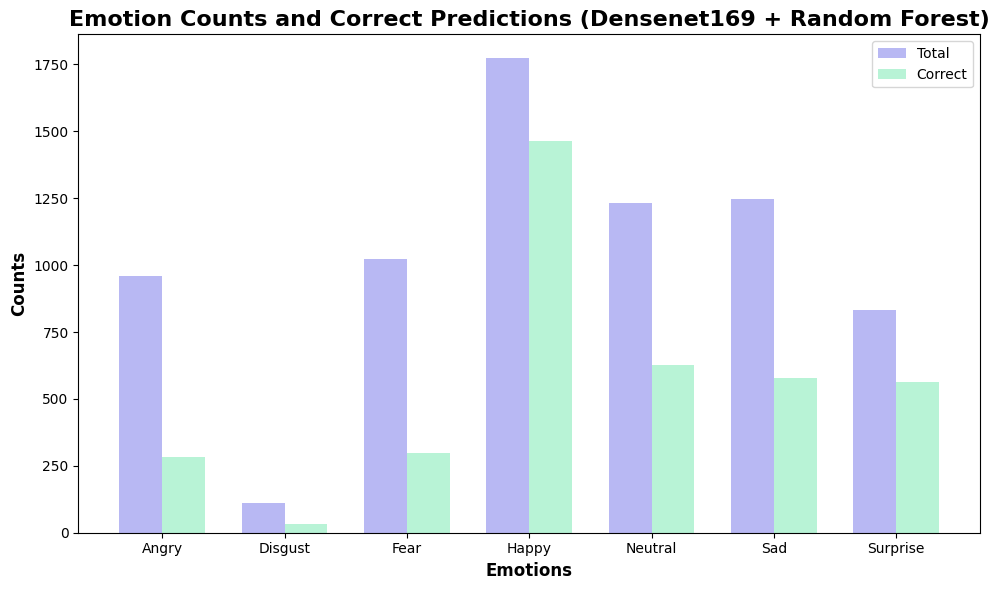

In [23]:
overview_dataset_statistics(rf_matrix, 'Densenet169 + Random Forest')

* **XGBOOST CLASSIFICATION**

In [24]:
xgb_acc, xgb_report, xgb_matrix = train_and_evaluate_classifier(xgb_classifier, densenet169_train_features, densenet169_test_features, train_labels_encoded, test_labels, le)
print("XGB Forest done")

XGB Forest done


In [25]:
print("Densenet169 + XGBoost Accuracy: {:.2f}%".format(xgb_acc * 100))
print("Densenet169 + XGBoost Classification Report:\n", xgb_report)

Densenet169 + XGBoost Accuracy: 59.06%
Densenet169 + XGBoost Classification Report:
               precision    recall  f1-score   support

       angry       0.51      0.44      0.48       958
     disgust       1.00      0.32      0.49       111
        fear       0.50      0.39      0.44      1024
       happy       0.72      0.81      0.76      1774
     neutral       0.51      0.57      0.54      1233
         sad       0.46      0.51      0.48      1247
    surprise       0.79      0.72      0.75       831

    accuracy                           0.59      7178
   macro avg       0.64      0.54      0.56      7178
weighted avg       0.59      0.59      0.59      7178



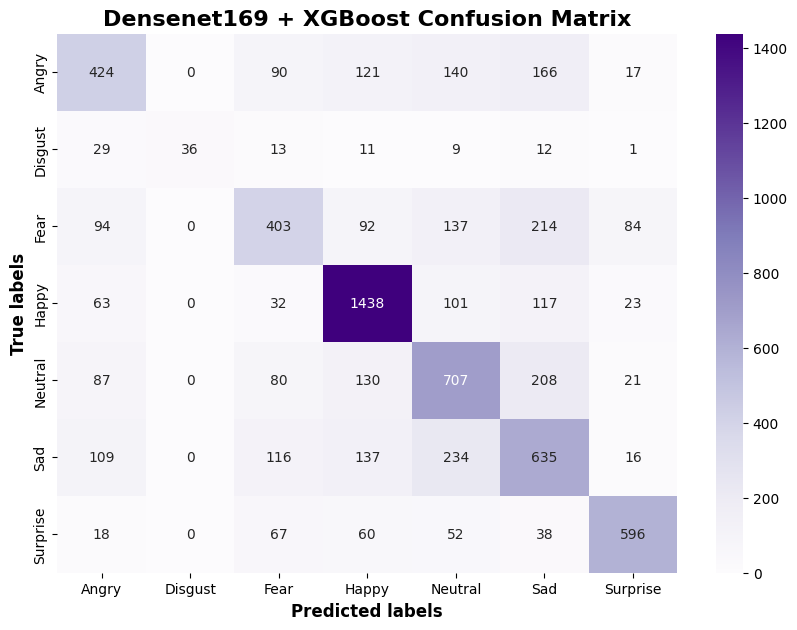

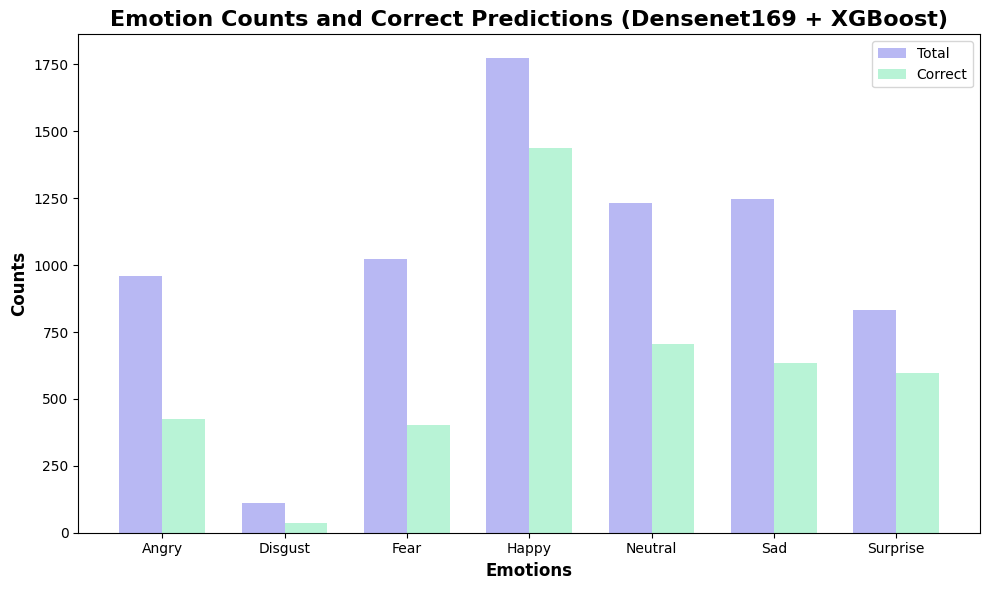

In [26]:
overview_dataset_statistics(xgb_matrix, 'Densenet169 + XGBoost')

* **KNN CLASSIFICATION**

In [31]:
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_acc, knn_report, knn_matrix = train_and_evaluate_classifier(knn_classifier, densenet169_train_features, densenet169_test_features, train_labels_encoded, test_labels, le)
print("KNN Classifier done")

KNN Classifier done


In [28]:
print("Densenet169 + KNN Accuracy: {:.2f}%".format(knn_acc * 100))
print("Densenet169 + KNN Classification Report:\n", knn_report)

Densenet169 + KNN Accuracy: 50.21%
Densenet169 + KNN Classification Report:
               precision    recall  f1-score   support

       angry       0.44      0.43      0.44       958
     disgust       0.45      0.67      0.54       111
        fear       0.47      0.46      0.47      1024
       happy       0.56      0.59      0.58      1774
     neutral       0.43      0.42      0.43      1233
         sad       0.43      0.39      0.41      1247
    surprise       0.68      0.70      0.69       831

    accuracy                           0.50      7178
   macro avg       0.50      0.52      0.51      7178
weighted avg       0.50      0.50      0.50      7178



In [29]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_acc, knn_report, knn_matrix = train_and_evaluate_classifier(knn_classifier, densenet169_train_features, densenet169_test_features, train_labels_encoded, test_labels, le)
print("KNN Classifier done")

KNN Classifier done


In [30]:
print("Densenet169 + KNN Accuracy: {:.2f}%".format(knn_acc * 100))
print("Densenet169 + KNN Classification Report:\n", knn_report)

Densenet169 + KNN Accuracy: 45.64%
Densenet169 + KNN Classification Report:
               precision    recall  f1-score   support

       angry       0.36      0.42      0.38       958
     disgust       0.28      0.35      0.31       111
        fear       0.38      0.37      0.38      1024
       happy       0.50      0.69      0.58      1774
     neutral       0.42      0.38      0.40      1233
         sad       0.44      0.28      0.34      1247
    surprise       0.68      0.51      0.58       831

    accuracy                           0.46      7178
   macro avg       0.44      0.43      0.43      7178
weighted avg       0.46      0.46      0.45      7178



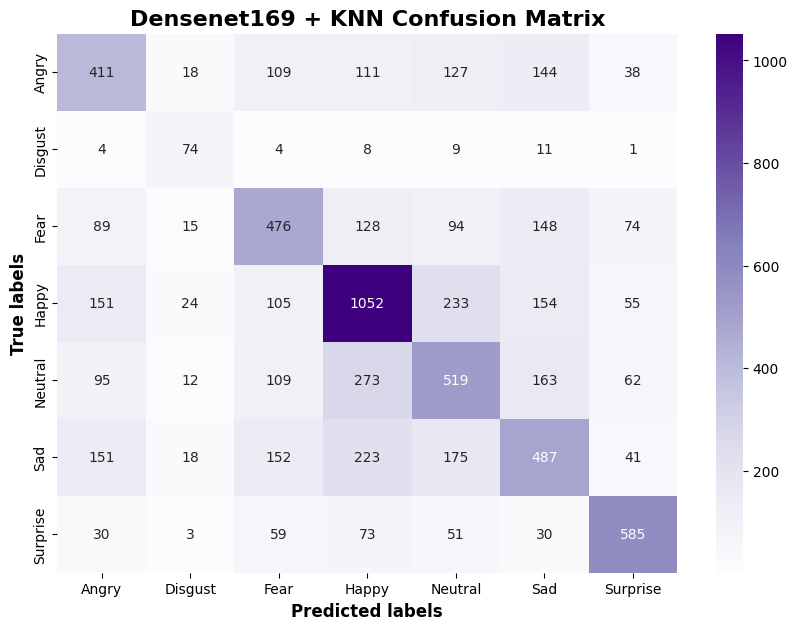

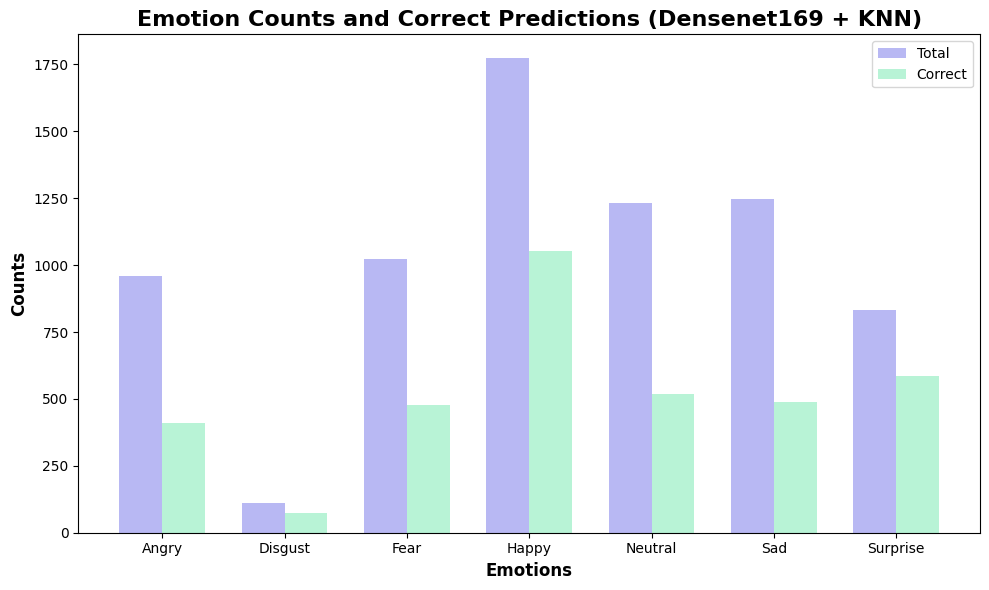

In [32]:
overview_dataset_statistics(knn_matrix, 'Densenet169 + KNN')

* **NEURAL NETWORK CLASSIFICATION**

In [25]:
cnn_densenet169_model=build_cnn_model(densenet169_model)

In [26]:
cnn_densenet169_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 102s 80ms/step - accuracy: 0.3929 - loss: 2.1691 - val_accuracy: 0.4805 - val_loss: 1.3626
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 92s 38ms/step - accuracy: 0.5068 - loss: 1.3100 - val_accuracy: 0.4960 - val_loss: 1.3394
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.5379 - loss: 1.2333 - val_accuracy: 0.5089 - val_loss: 1.3190
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.5610 - loss: 1.1666 - val_accuracy: 0.5091 - val_loss: 1.3120
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.5758 - loss: 1.1274 - val_accuracy: 0.5163 - val_loss: 1.3023
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.5994 - loss: 1.0704 - val_accuracy: 0.5189 - val_loss: 1.3263
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.5997 - loss: 1.0595 - val_accuracy: 0.5067 - val_loss: 1.3558
Epoch 8/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.6123 - loss: 1.0320 -

In [27]:
predictions = cnn_densenet169_model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(y_test, axis=1)
cnn_acc = accuracy_score(test_labels, predictions)
cnn_report = classification_report(test_labels, predictions)
cnn_matrix = confusion_matrix(test_labels, predictions)

225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step


In [28]:
print("Densenet169 + DeepLearning Accuracy: {:.2f}%".format(cnn_acc * 100))
print("Densenet169 + DeepLearning Classification Report:\n", cnn_report)

Densenet169 + DeepLearning Accuracy: 52.05%
Densenet169 + DeepLearning Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.46      0.43       958
           1       0.46      0.41      0.43       111
           2       0.40      0.35      0.37      1024
           3       0.78      0.64      0.70      1774
           4       0.45      0.55      0.50      1233
           5       0.47      0.35      0.40      1247
           6       0.55      0.75      0.64       831

    accuracy                           0.52      7178
   macro avg       0.50      0.50      0.50      7178
weighted avg       0.53      0.52      0.52      7178



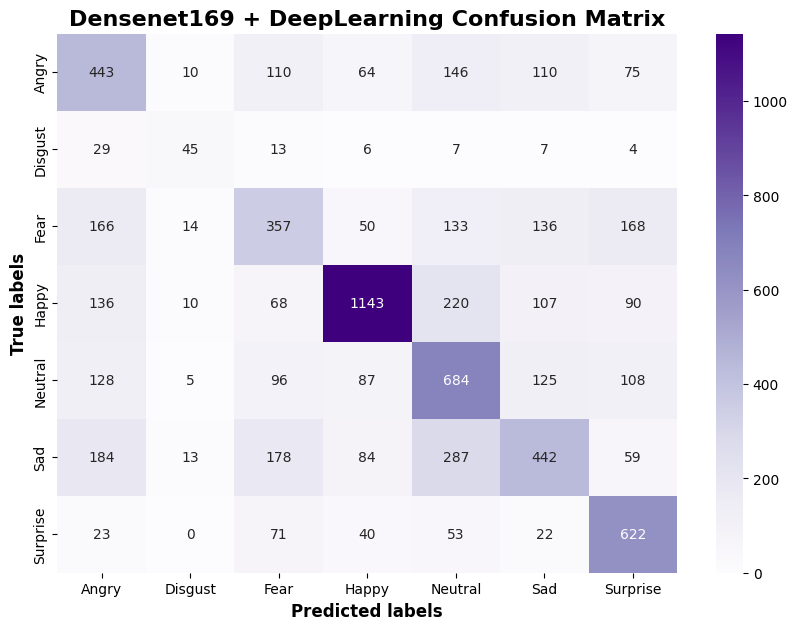

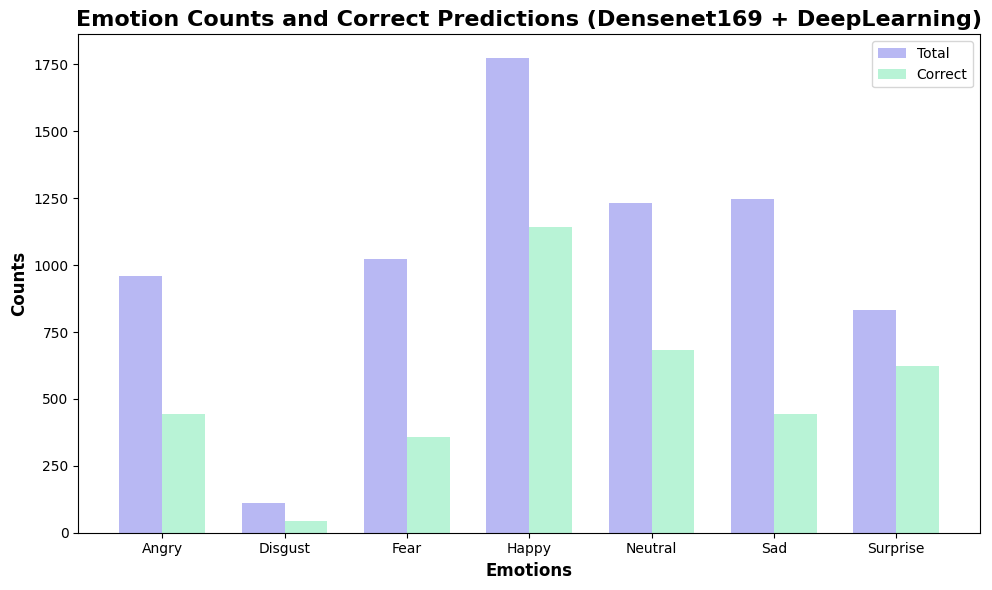

In [29]:
overview_dataset_statistics(cnn_matrix, 'Densenet169 + DeepLearning')

# **3. Densenet201**

In [28]:
from keras.applications import DenseNet201

In [29]:
densenet201_model = DenseNet201(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in densenet201_model.layers:
    layer.trainable = False

densenet201_train_features = extract_features(densenet201_model, x_train)
densenet201_test_features = extract_features(densenet201_model, x_test)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
  5/898 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step 

I0000 00:00:1717493863.806022     182 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


898/898 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step


* **RANDOM FOREST CLASSIFICATION**

In [30]:
rf_acc, rf_report, rf_matrix = train_and_evaluate_classifier(rf_classifier, densenet201_train_features, densenet201_test_features, train_labels_encoded, test_labels, le)
print("Densenet201 + Random Forest done")

Densenet201 + Random Forest done


In [31]:
print("Densenet201 + Random Forest Accuracy: {:.2f}%".format(rf_acc * 100) )
print("Densenet201 + Random Forest Classification Report:\n", rf_report)

Densenet201 + Random Forest Accuracy: 54.26%
Densenet201 + Random Forest Classification Report:
               precision    recall  f1-score   support

       angry       0.58      0.29      0.39       958
     disgust       1.00      0.32      0.49       111
        fear       0.59      0.32      0.42      1024
       happy       0.54      0.85      0.66      1774
     neutral       0.48      0.47      0.47      1233
         sad       0.44      0.48      0.46      1247
    surprise       0.77      0.68      0.72       831

    accuracy                           0.54      7178
   macro avg       0.63      0.49      0.52      7178
weighted avg       0.56      0.54      0.53      7178



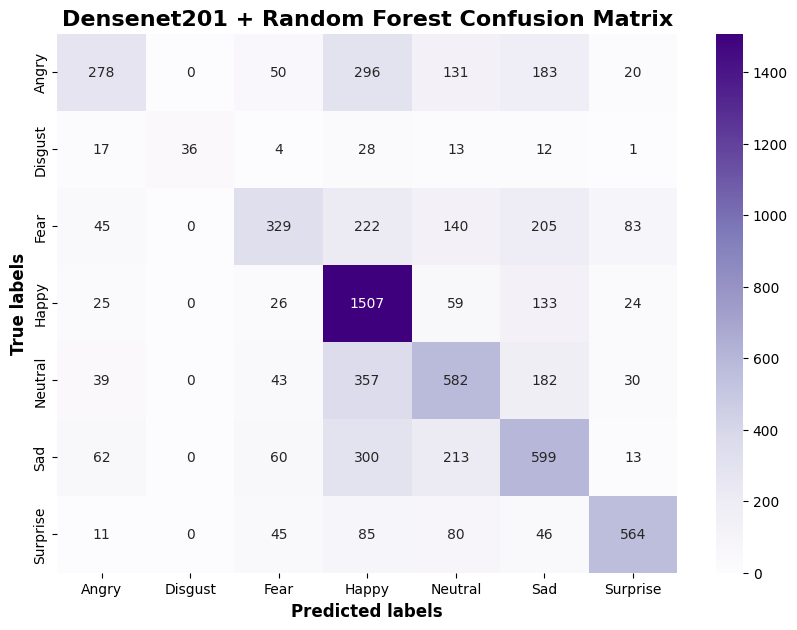

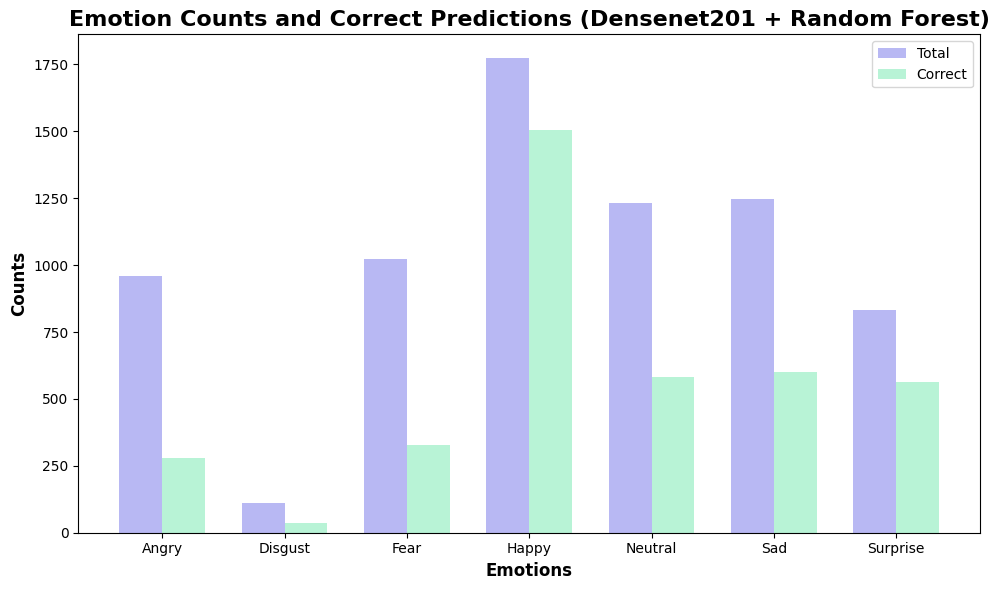

In [32]:
overview_dataset_statistics(rf_matrix, "Densenet201 + Random Forest")

* **XGBOOST CLASSIFICATION**

In [33]:
xgb_acc, xgb_report, xgb_matrix = train_and_evaluate_classifier(xgb_classifier, densenet201_train_features, densenet201_test_features, train_labels_encoded, test_labels, le)
print("XGB Forest done")

XGB Forest done


In [34]:
print("Densenet201 + XGBoost Accuracy: {:.2f}%".format(xgb_acc * 100) )
print("Densenet201 + XGBoost Classification Report:\n", xgb_report)

Densenet201 + XGBoost Accuracy: 58.99%
Densenet201 + XGBoost Classification Report:
               precision    recall  f1-score   support

       angry       0.51      0.46      0.48       958
     disgust       1.00      0.36      0.53       111
        fear       0.49      0.40      0.44      1024
       happy       0.73      0.81      0.76      1774
     neutral       0.51      0.58      0.54      1233
         sad       0.46      0.50      0.48      1247
    surprise       0.78      0.71      0.74       831

    accuracy                           0.59      7178
   macro avg       0.64      0.54      0.57      7178
weighted avg       0.59      0.59      0.59      7178



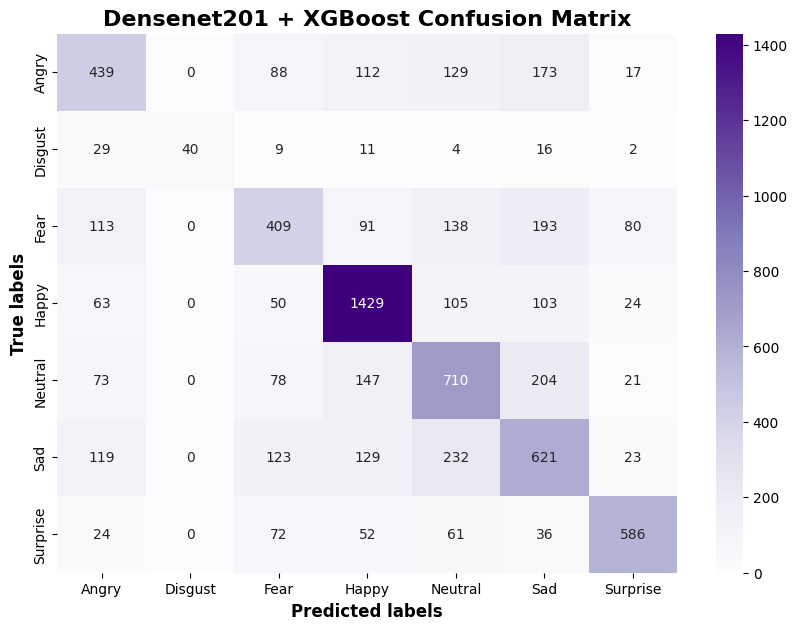

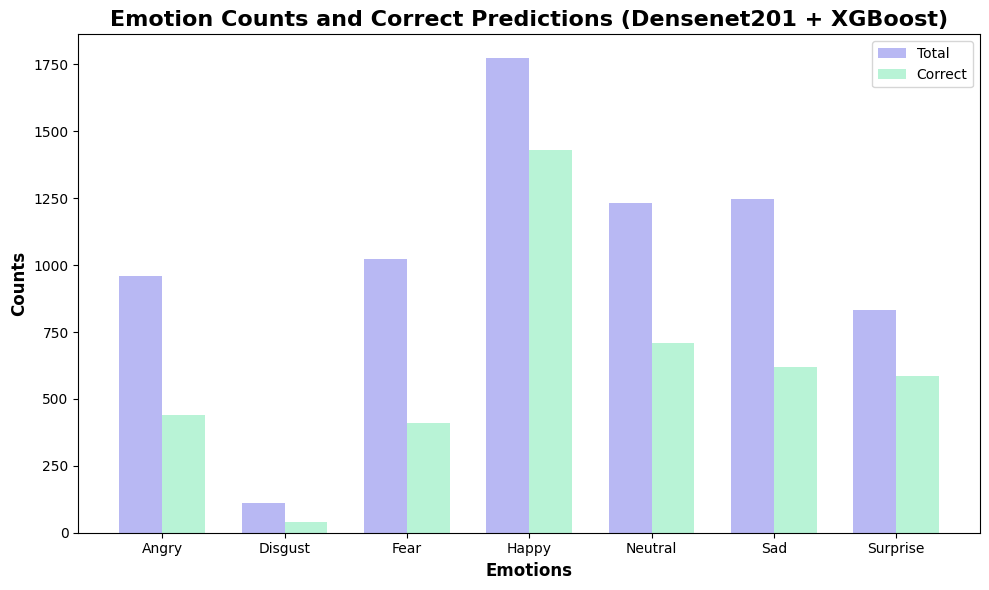

In [35]:
overview_dataset_statistics(xgb_matrix, "Densenet201 + XGBoost")

* **KNN CLASSIFICATION**

In [37]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_acc, knn_report, knn_matrix = train_and_evaluate_classifier(knn_classifier, densenet201_train_features, densenet201_test_features, train_labels_encoded, test_labels, le)
print("KNN Classifier done")

KNN Classifier done


In [39]:
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_acc, knn_report, knn_matrix = train_and_evaluate_classifier(knn_classifier, densenet201_train_features, densenet201_test_features, train_labels_encoded, test_labels, le)
print("KNN Classifier done")

KNN Classifier done


In [40]:
print("Densenet201 + KNN Accuracy: {:.2f}%".format(knn_acc * 100))
print("Densenet201 + KNN Classification Report:\n", knn_report)

Densenet201 + KNN Accuracy: 51.27%
Densenet201 + KNN Classification Report:
               precision    recall  f1-score   support

       angry       0.45      0.45      0.45       958
     disgust       0.53      0.69      0.60       111
        fear       0.47      0.47      0.47      1024
       happy       0.55      0.61      0.58      1774
     neutral       0.46      0.42      0.44      1233
         sad       0.46      0.42      0.44      1247
    surprise       0.68      0.71      0.70       831

    accuracy                           0.51      7178
   macro avg       0.51      0.54      0.52      7178
weighted avg       0.51      0.51      0.51      7178



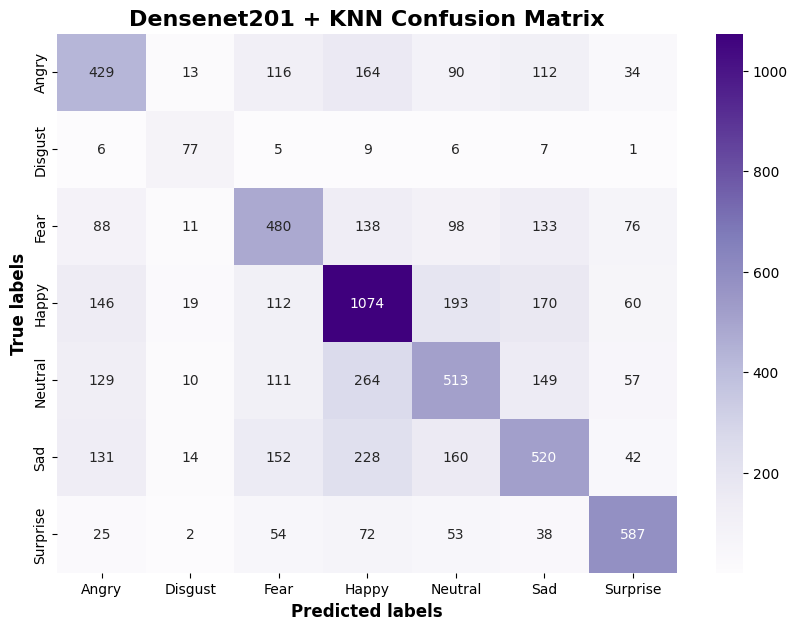

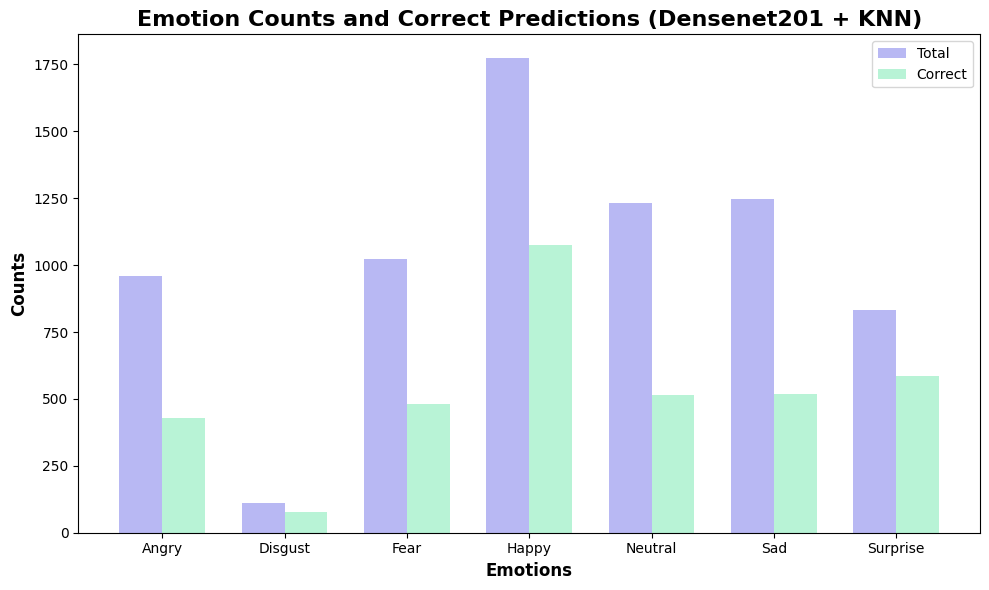

In [41]:
overview_dataset_statistics(knn_matrix, 'Densenet201 + KNN')

* **NEURAL NETWORK CLASSIFICATION**

In [42]:
cnn_densenet201_model=build_cnn_model(densenet201_model)

In [43]:
cnn_densenet201_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 128s 101ms/step - accuracy: 0.3989 - loss: 2.1459 - val_accuracy: 0.4897 - val_loss: 1.3471
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.5196 - loss: 1.2759 - val_accuracy: 0.5099 - val_loss: 1.2947
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.5412 - loss: 1.2202 - val_accuracy: 0.4990 - val_loss: 1.3209
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.5633 - loss: 1.1604 - val_accuracy: 0.5198 - val_loss: 1.2801
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.5822 - loss: 1.1139 - val_accuracy: 0.5202 - val_loss: 1.2924
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.5988 - loss: 1.0791 - val_accuracy: 0.5368 - val_loss: 1.2655
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.6153 - loss: 1.0345 - val_accuracy: 0.5150 - val_loss: 1.2812
Epoch 8/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.6235 - loss: 1.0122 

In [44]:
predictions = cnn_densenet201_model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(y_test, axis=1)
cnn_acc = accuracy_score(test_labels, predictions)
cnn_report = classification_report(test_labels, predictions)
cnn_matrix = confusion_matrix(test_labels, predictions)

225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step


In [45]:
print("Densenet201 + DeepLearning Accuracy: {:.2f}%".format(cnn_acc * 100) )
print("Densenet201 + DeepLearning Classification Report:\n", cnn_report)

Densenet201 + DeepLearning Accuracy: 54.17%
Densenet201 + DeepLearning Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.28      0.37       958
           1       0.44      0.51      0.48       111
           2       0.47      0.31      0.38      1024
           3       0.64      0.80      0.71      1774
           4       0.52      0.41      0.46      1233
           5       0.39      0.54      0.46      1247
           6       0.64      0.77      0.69       831

    accuracy                           0.54      7178
   macro avg       0.53      0.52      0.51      7178
weighted avg       0.54      0.54      0.53      7178



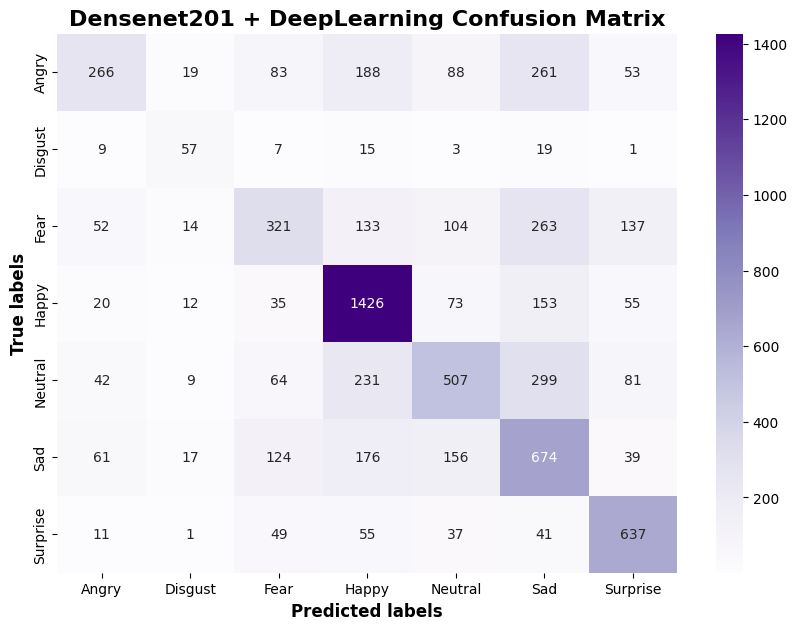

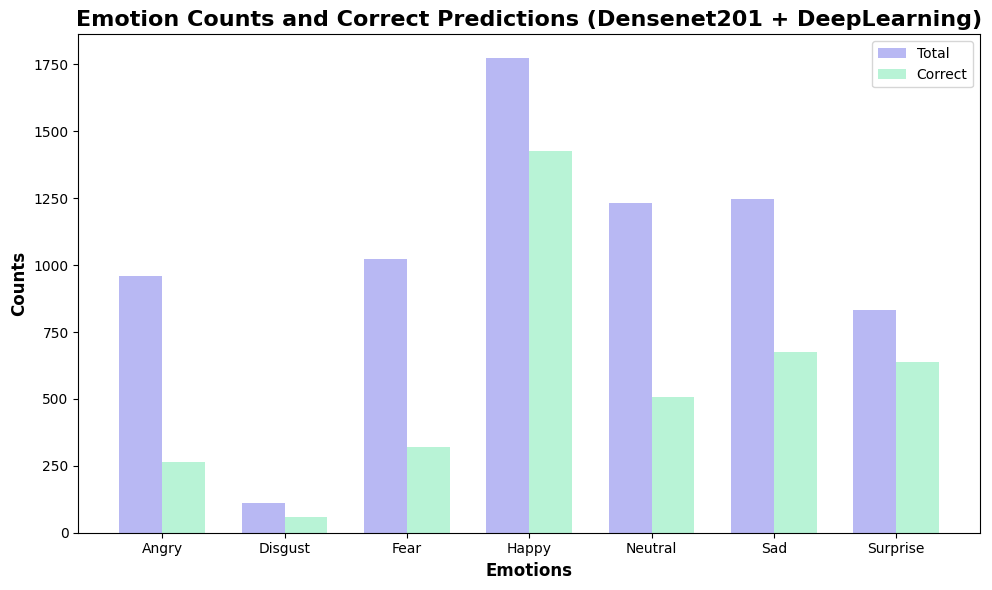

In [47]:
overview_dataset_statistics(cnn_matrix, 'Densenet201 + DeepLearning')

# **4. MobileNetV2**

In [16]:
mobilenetv2_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in mobilenetv2_model.layers:
    layer.trainable = False

mobilenetv2_train_features = extract_features(mobilenetv2_model, x_train)
mobilenetv2_test_features = extract_features(mobilenetv2_model, x_test)

/tmp/ipykernel_34/3145037516.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetv2_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
 22/898 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step

I0000 00:00:1717503266.006987     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


* **RANDOM FOREST CLASSIFICATION**

In [17]:
rf_acc, rf_report, rf_matrix = train_and_evaluate_classifier(rf_classifier, mobilenetv2_train_features, mobilenetv2_test_features, train_labels_encoded, test_labels, le)
print("Random Forest done")

Random Forest done


In [18]:
print("MobileNetV2 + Random Forest Accuracy: ", rf_acc)
print("MobileNetV2 + Random Forest Classification Report:\n", rf_report)

MobileNetV2 + Random Forest Accuracy:  0.5022290331568682
MobileNetV2 + Random Forest Classification Report:
               precision    recall  f1-score   support

       angry       0.57      0.26      0.36       958
     disgust       1.00      0.28      0.44       111
        fear       0.53      0.29      0.38      1024
       happy       0.48      0.81      0.60      1774
     neutral       0.47      0.42      0.44      1233
         sad       0.41      0.45      0.43      1247
    surprise       0.74      0.60      0.67       831

    accuracy                           0.50      7178
   macro avg       0.60      0.45      0.47      7178
weighted avg       0.52      0.50      0.49      7178



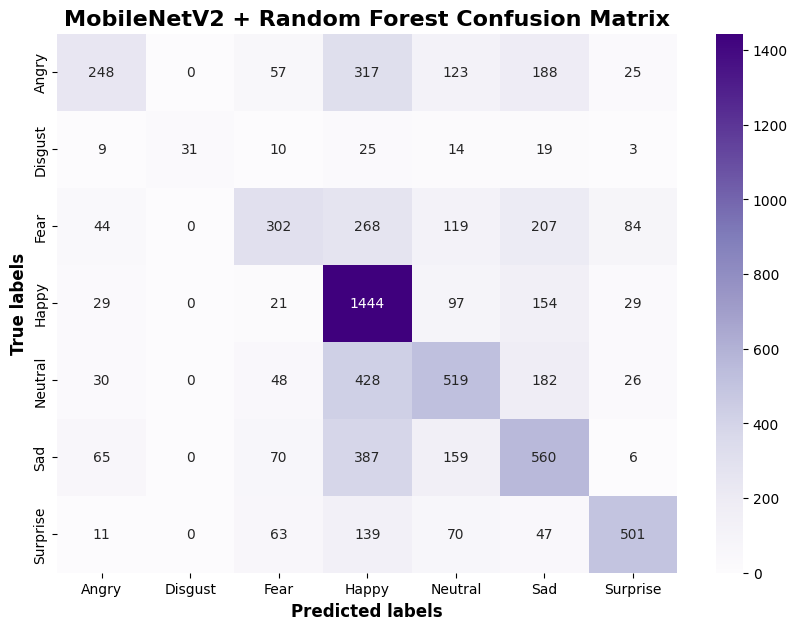

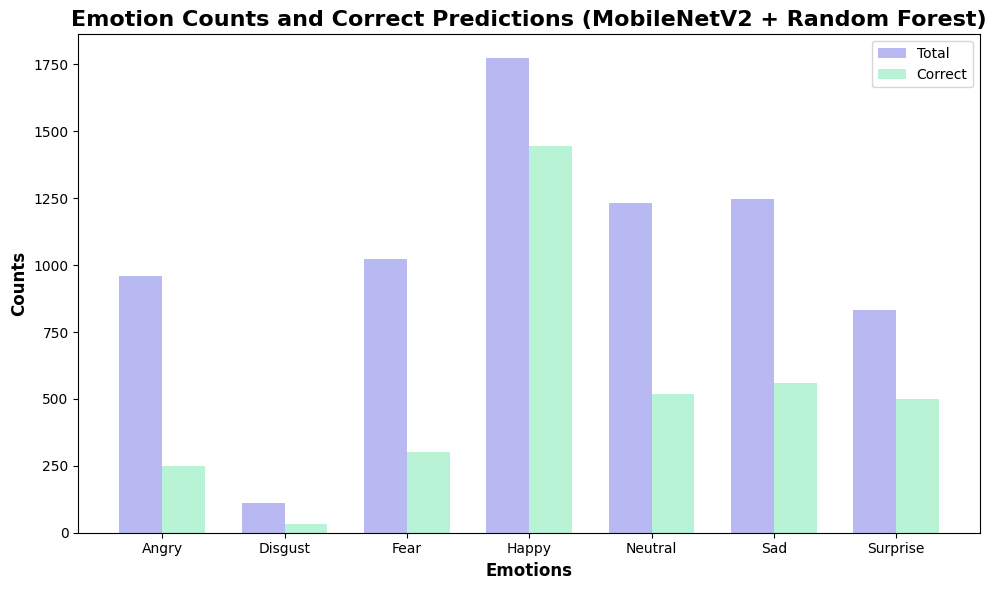

In [21]:
overview_dataset_statistics(rf_matrix, 'MobileNetV2 + Random Forest')

* **XGBOOST CLASSIFICATION**

In [22]:
xgb_acc, xgb_report, xgb_matrix = train_and_evaluate_classifier(xgb_classifier, mobilenetv2_train_features, mobilenetv2_test_features, train_labels_encoded, test_labels, le)
print("XGB Forest done")

XGB Forest done


In [24]:
print("MobileNetV2 + XGBoost Accuracy: {:.2f}%".format(xgb_acc * 100) )
print("MobileNetV2 + XGBoost Classification Report:\n", xgb_report)

MobileNetV2 + XGBoost Accuracy: 52.88%
MobileNetV2 + XGBoost Classification Report:
               precision    recall  f1-score   support

       angry       0.44      0.36      0.40       958
     disgust       1.00      0.31      0.47       111
        fear       0.44      0.37      0.40      1024
       happy       0.63      0.74      0.68      1774
     neutral       0.46      0.50      0.48      1233
         sad       0.42      0.45      0.43      1247
    surprise       0.75      0.65      0.70       831

    accuracy                           0.53      7178
   macro avg       0.59      0.48      0.51      7178
weighted avg       0.53      0.53      0.52      7178



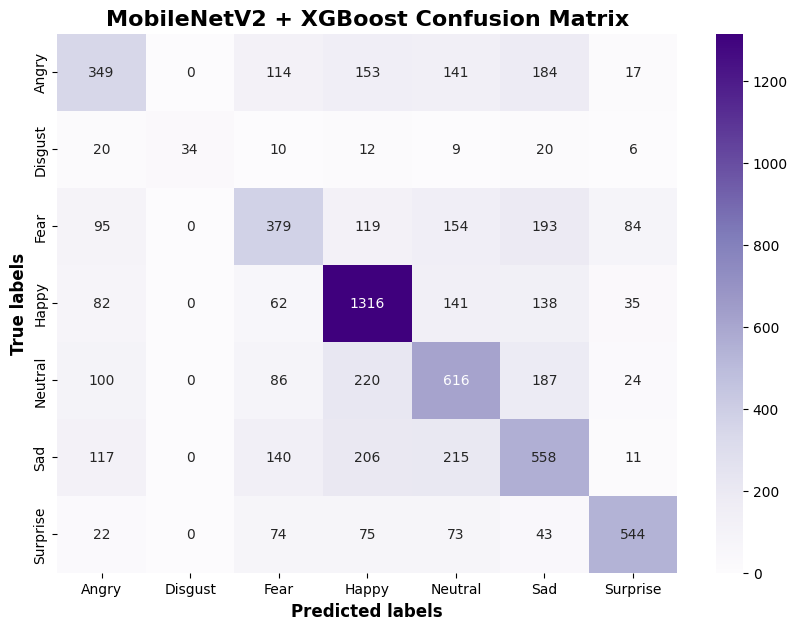

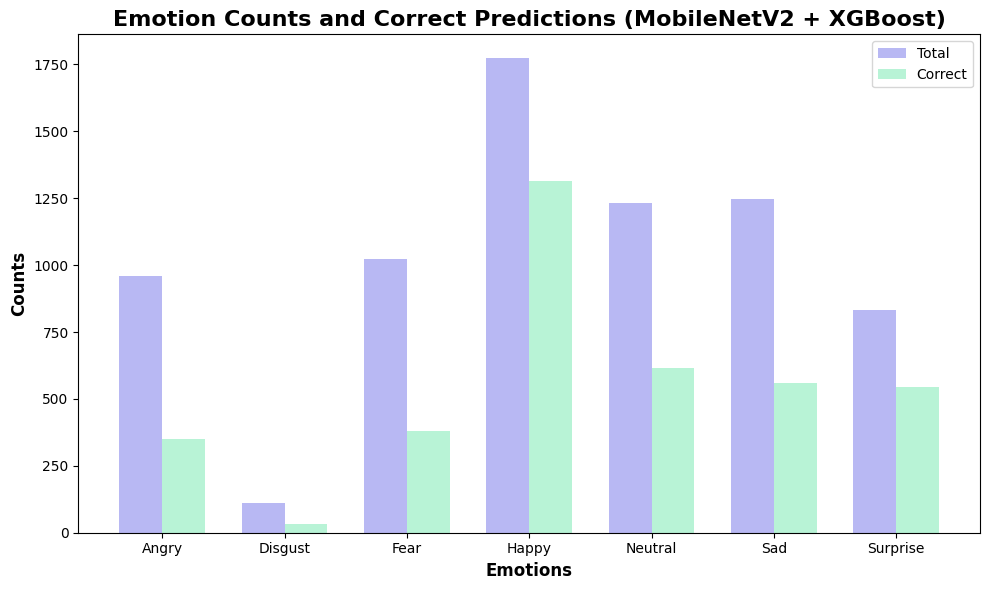

In [25]:
overview_dataset_statistics(xgb_matrix, "MobileNetV2 + XGBoost")

* **KNN CLASSIFICATION**

In [26]:
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_acc, knn_report, knn_matrix = train_and_evaluate_classifier(knn_classifier, mobilenetv2_train_features, mobilenetv2_test_features, train_labels_encoded, test_labels, le)
print("KNN Classifier done")

KNN Classifier done


In [27]:
print("MobileNetV2 + KNN Accuracy: {:.2f}%".format(knn_acc * 100))
print("MobileNetV2 + KNN Classification Report:\n", knn_report)

MobileNetV2 + KNN Accuracy: 49.37%
MobileNetV2 + KNN Classification Report:
               precision    recall  f1-score   support

       angry       0.43      0.42      0.42       958
     disgust       0.46      0.65      0.54       111
        fear       0.49      0.45      0.47      1024
       happy       0.53      0.60      0.56      1774
     neutral       0.41      0.39      0.40      1233
         sad       0.44      0.39      0.41      1247
    surprise       0.70      0.69      0.69       831

    accuracy                           0.49      7178
   macro avg       0.49      0.51      0.50      7178
weighted avg       0.49      0.49      0.49      7178



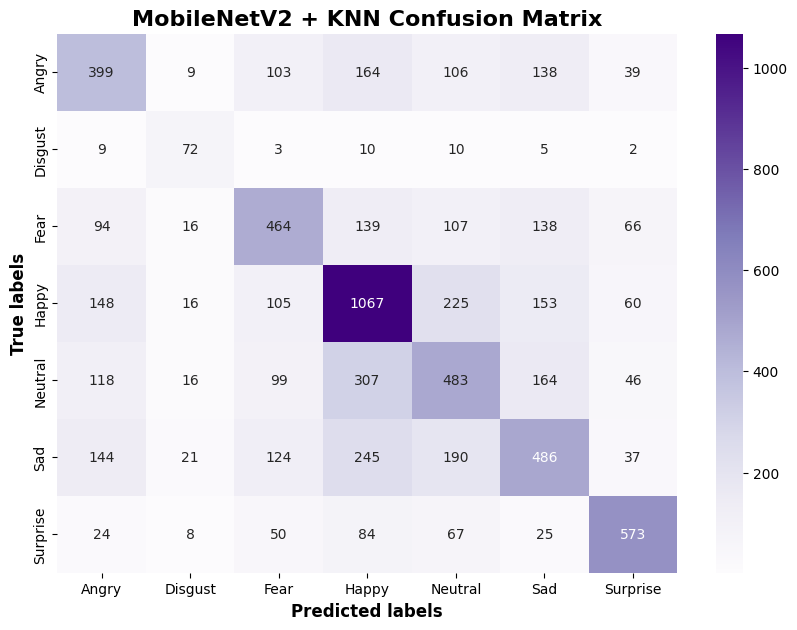

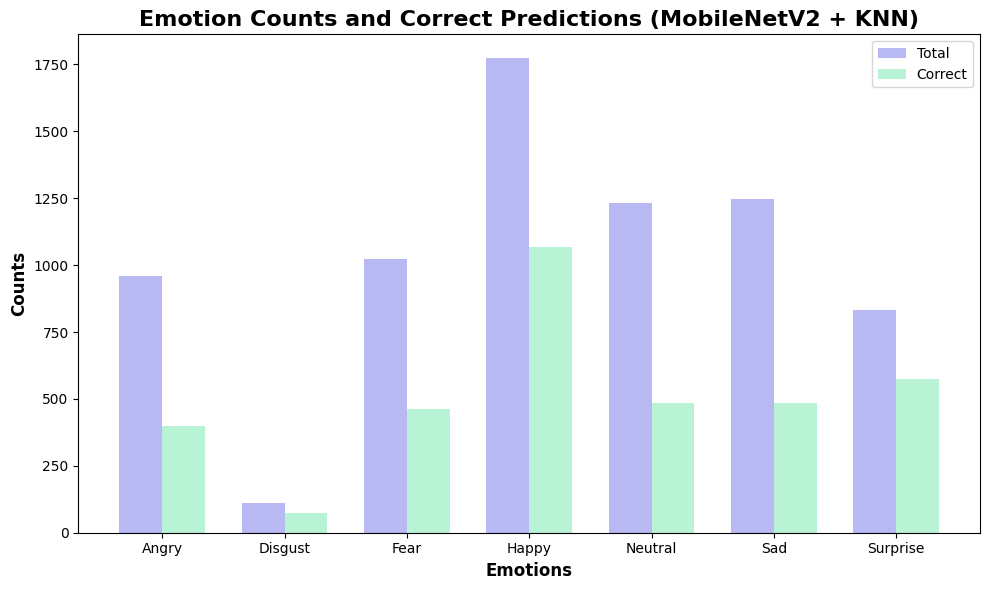

In [28]:
overview_dataset_statistics(knn_matrix, 'MobileNetV2 + KNN')

* **NEURAL NETWORK CLASSIFICATION**

In [29]:
cnn_mobilenetv2_model=build_cnn_model(mobilenetv2_model)


In [31]:
cnn_mobilenetv2_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.3746 - loss: 4.1428 - val_accuracy: 0.4685 - val_loss: 1.3839
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5109 - loss: 1.3117 - val_accuracy: 0.4834 - val_loss: 1.3741
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5588 - loss: 1.1843 - val_accuracy: 0.4989 - val_loss: 1.3862
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6049 - loss: 1.0810 - val_accuracy: 0.4986 - val_loss: 1.3515
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6352 - loss: 1.0030 - val_accuracy: 0.5157 - val_loss: 1.3663
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6704 - loss: 0.9075 - val_accuracy: 0.5099 - val_loss: 1.4055
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6975 - loss: 0.8426 - val_accuracy: 0.4968 - val_loss: 1.5172
Epoch 8/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7325 - loss: 0.7538 - 

In [32]:
predictions = cnn_mobilenetv2_model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(y_test, axis=1)
cnn_acc = accuracy_score(test_labels, predictions)
cnn_report = classification_report(test_labels, predictions)
cnn_matrix = confusion_matrix(test_labels, predictions)

225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step


In [33]:
print("MobileNetV2 + DeepLearning Accuracy: {:.2f}%".format(cnn_acc * 100) )
print("MobileNetV2 + DeepLearning Classification Report:\n", cnn_report)

MobileNetV2 + DeepLearning Accuracy: 50.70%
MobileNetV2 + DeepLearning Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.40      0.41       958
           1       0.25      0.46      0.33       111
           2       0.42      0.36      0.39      1024
           3       0.68      0.65      0.67      1774
           4       0.44      0.50      0.47      1233
           5       0.40      0.44      0.42      1247
           6       0.71      0.61      0.66       831

    accuracy                           0.51      7178
   macro avg       0.48      0.49      0.48      7178
weighted avg       0.52      0.51      0.51      7178



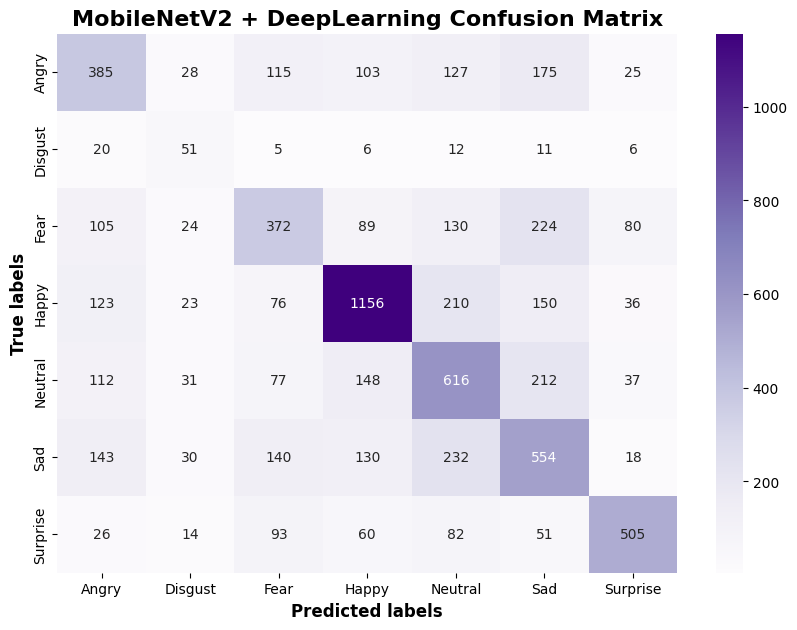

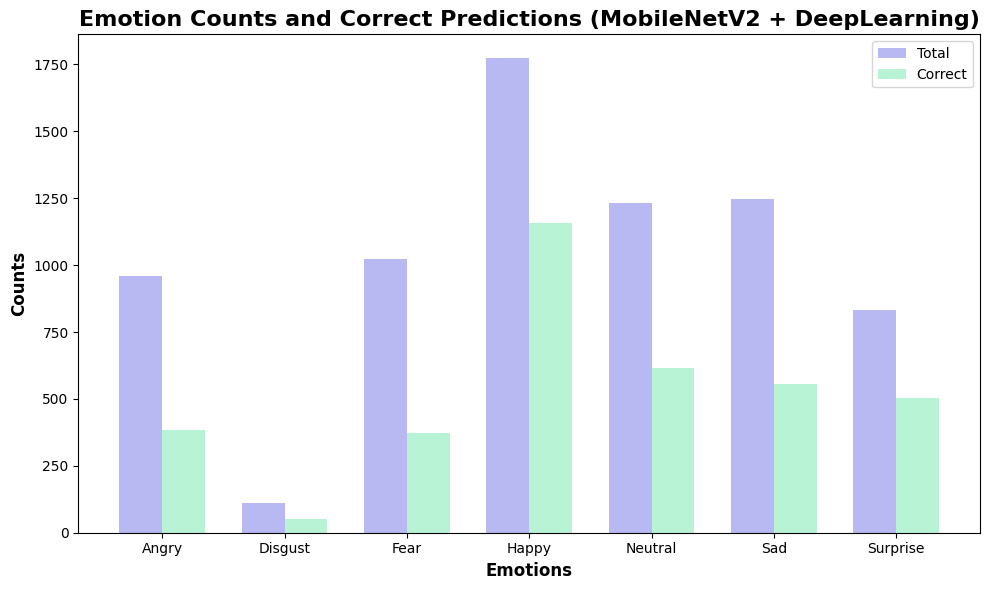

In [35]:
overview_dataset_statistics(cnn_matrix, 'MobileNetV2 + DeepLearning')